# Entanglement & N-Token Disambiguation Demo

This notebook demonstrates building n-token lookup tables (LUTs), visualizing entanglement between tokens, and performing disambiguation of (reg, zeros) identifiers back into candidate token sets. It uses a small synthetic dataset and simple visualizations.

In [1]:
# --- Imports & Environment Setup
import hashlib
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from IPython.display import display

# Import project classes (fall back to local lightweight stubs if unavailable)
try:
    from core.manifold_os import NTokenRepresentation, LUTRecord, IngestionAdjacencyMatrix
    from core.hllset import HLLSet
    print('Imported project core classes')
except Exception as e:
    print('Project imports failed, notebook will use local lightweight fallbacks:', e)

# Deterministic behavior for demo
np.random.seed(42)
random.seed(42)
%matplotlib inline

Imported project core classes


In [2]:
# --- Lightweight fallbacks (used only if project imports failed)
try:
    NTokenRepresentation
except NameError:
    from collections import defaultdict
    class LUTRecord:
        def __init__(self, reg, zeros):
            self.reg = reg
            self.zeros = zeros
            self.tokens = []
        def add_entry(self, h, token_seq):
            self.tokens.append(token_seq)
        def get_candidates(self):
            cand = set()
            for seq in self.tokens:
                cand.update(seq)
            return cand

    class NTokenRepresentation:
        def __init__(self, original_tokens):
            self.original_tokens = original_tokens
            self.n_token_groups = {}
            self.luts = {}
            self.hllsets = {}
        def generate_n_tokens(self, n, maintain_order=True):
            if n < 1 or n > len(self.original_tokens):
                return []
            if maintain_order:
                res = []
                for i in range(len(self.original_tokens)-n+1):
                    res.append(tuple(self.original_tokens[i:i+n]))
                return res
            else:
                from itertools import combinations
                return [tuple(c) for c in combinations(self.original_tokens, n)]
        def build_n_token_groups(self, ns, maintain_order=True):
            for n in ns:
                self.n_token_groups[n] = self.generate_n_tokens(n, maintain_order)
        def disambiguate_tokens(self, reg, zeros):
            candidate_sets = []
            key = (reg, zeros)
            for n, lut in self.luts.items():
                if key in lut:
                    candidate_sets.append(lut[key].get_candidates())
            if not candidate_sets:
                return set()
            res = candidate_sets[0].copy()
            for s in candidate_sets[1:]:
                res.intersection_update(s)
            return res

    class IngestionAdjacencyMatrix:
        def __init__(self):
            self.cells = {}
            self.START_ID = ('START', 0)
            self.END_ID = ('END', 0)
        def get_or_create_cell(self, row_id, col_id):
            key = (row_id, col_id)
            if key not in self.cells:
                self.cells[key] = {'frequency':0}
            return self.cells[key]
        def update_cell(self, row_id, col_id):
            c = self.get_or_create_cell(row_id, col_id)
            c['frequency'] += 1
        def get_row_ids(self):
            rows=set()
            for (r,c) in self.cells.keys():
                rows.add(r)
            return rows

    # Minimal HLLSet stub for deterministic reg/zeros mapping
    class HLLSet:
        @staticmethod
        def compute_reg_zeros_batch(tokens, p_bits=10, seed=42):
            out=[]
            for t in tokens:
                h = hashlib.sha1((str(seed)+'|'+t).encode()).hexdigest()
                val = int(h[:16],16)
                reg = val % (2**p_bits)
                # tz: count trailing zeros in val (simple proxy)
                tz = (val & -val).bit_length()-1 if val!=0 else 0
                tz = tz % 32
                out.append((reg, tz))
            return out


In [3]:
# --- Generate synthetic tokens and build n-token LUTs
tokens = ['alice','loves','bob','and','alice']
print('Original tokens:', tokens)

# create representation with 1- and 2-token groups
rep = NTokenRepresentation(tokens)
rep.build_n_token_groups([1,2], maintain_order=True)

# compute reg/zeros for single tokens (1-token groups)
pairs = HLLSet.compute_reg_zeros_batch(tokens, p_bits=10, seed=42)
print('Computed (reg,zeros) pairs:')
for t,p in zip(tokens,pairs):
    print(t, p)

# Build LUTs for each n group: map (reg,zeros) to LUTRecord containing tokens
for n, group in rep.n_token_groups.items():
    lut = {}
    # For each n-token tuple, compute pairs for constituent tokens and add entries
    for seq in group:
        # For lookup we can use reg/zeros of the first token in the tuple (demo simplification)
        seq_tokens = list(seq)
        seq_pairs = HLLSet.compute_reg_zeros_batch(seq_tokens, p_bits=10, seed=42)
        for tok, pair in zip(seq_tokens, seq_pairs):
            key = pair
            if key not in lut:
                lut[key] = LUTRecord(reg=pair[0], zeros=pair[1])
            lut[key].add_entry(hash(tok), tuple(seq_tokens))
    rep.luts[n] = lut

print('\nBuilt LUT sizes per n:')
for n in rep.luts:
    print('n=', n, 'entries=', len(rep.luts[n]))

Original tokens: ['alice', 'loves', 'bob', 'and', 'alice']
Computed (reg,zeros) pairs:
alice (423, 2)
loves (361, 0)
bob (356, 0)
and (235, 1)
alice (423, 2)

Built LUT sizes per n:
n= 1 entries= 4
n= 2 entries= 4


In [4]:
# --- Inspect LUTs and demonstrate disambiguation
# pick the first token's pair
reg0, zeros0 = pairs[0]
print('\nLooking up candidates for first token pair:', (reg0, zeros0))
for n, lut in rep.luts.items():
    if (reg0, zeros0) in lut:
        print(f'n={n} candidates:', lut[(reg0, zeros0)].get_candidates())

# Use canonical disambiguation
candidates = rep.disambiguate_tokens(reg0, zeros0)
print('\nIntersection result (disambiguation):', candidates)


Looking up candidates for first token pair: (423, 2)
n=1 candidates: {'alice'}
n=2 candidates: {'alice', 'loves'}

Intersection result (disambiguation): {'alice'}


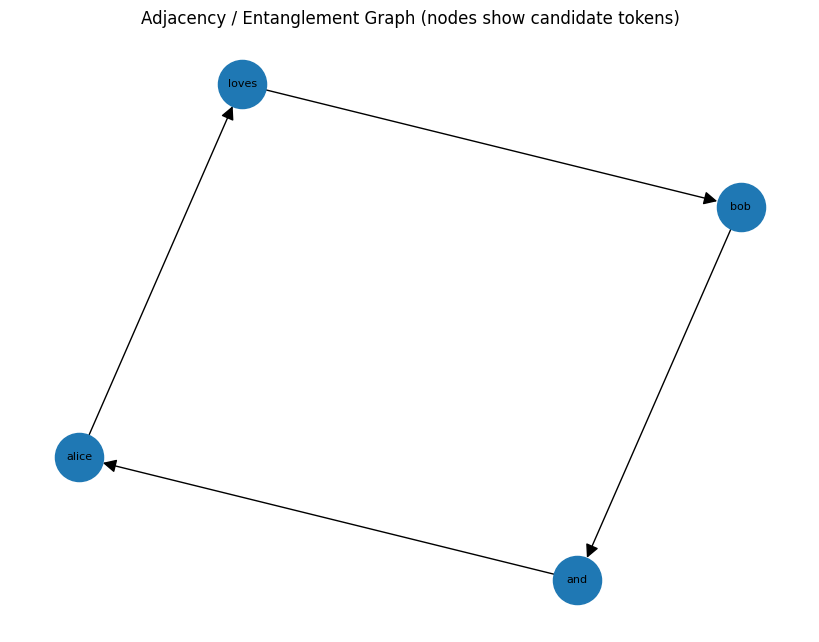

In [5]:
# --- Build Adjacency Matrix and visualize entanglement graph
am = IngestionAdjacencyMatrix()
# create transitions from token pairs
for i in range(len(pairs)-1):
    row = pairs[i]
    col = pairs[i+1]
    am.update_cell(row, col)

# Build networkx graph for visualization
G = nx.DiGraph()
for (r,c), cell in am.cells.items():
    # node labels show a short list of candidates
    lab_r = ','.join(sorted(list(rep.disambiguate_tokens(r[0], r[1])))) if rep.disambiguate_tokens(r[0], r[1]) else str(r)
    lab_c = ','.join(sorted(list(rep.disambiguate_tokens(c[0], c[1])))) if rep.disambiguate_tokens(c[0], c[1]) else str(c)
    G.add_node(r, label=lab_r)
    G.add_node(c, label=lab_c)
    # Handle both AMCell object (attr) and dict fallback
    freq = cell.frequency if hasattr(cell, 'frequency') else cell.get('frequency', 1)
    G.add_edge(r, c, weight=freq)

# draw graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8,6))
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=False, node_size=1200, arrowsize=20, width=[max(1,w) for w in weights])
# draw labels separately
node_labels = {n: d['label'] for n,d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
plt.title('Adjacency / Entanglement Graph (nodes show candidate tokens)')
plt.show()

In [6]:
# --- Greedy reconstruction from AM using disambiguation
# Start from first pair
start = pairs[0]
reconstructed = []
current = start
steps = 0
max_steps = len(tokens)
while steps < max_steps:
    # pick highest-frequency outgoing
    outs = []
    for (row, col), cell in am.cells.items():
        if row == current:
            freq = cell.frequency if hasattr(cell, 'frequency') else cell.get('frequency', 1)
            outs.append((col, freq))
    if not outs:
        break
    outs_sorted = sorted(outs, key=lambda x: x[1], reverse=True)
    next_id = outs_sorted[0][0]
    cands = rep.disambiguate_tokens(next_id[0], next_id[1])
    token = sorted(cands)[0] if cands else f"<unknown:{next_id}>"
    reconstructed.append(token)
    current = next_id
    steps += 1

print('Original tokens:', tokens)
print('Reconstructed (greedy):', reconstructed)

Original tokens: ['alice', 'loves', 'bob', 'and', 'alice']
Reconstructed (greedy): ['loves', 'bob', 'and', 'alice', 'loves']


Bits with ground-truth present in candidate set: 5/5 (fraction 1.00)
Average candidate set size: 1.0


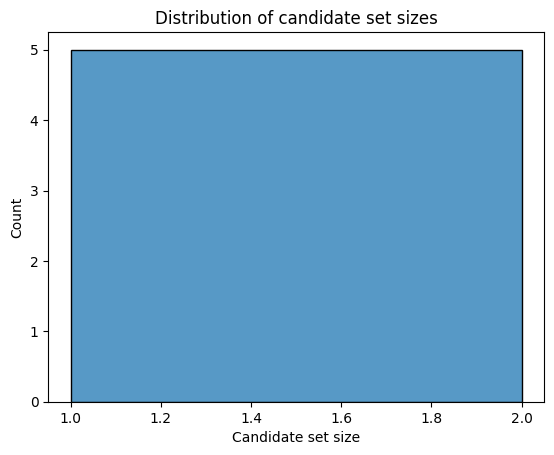

In [7]:
# --- Evaluation metrics: candidate coverage and sizes
all_keys = []
present = 0
sizes = []
for t, pair in zip(tokens, pairs):
    key = pair
    all_keys.append(key)
    cands = rep.disambiguate_tokens(key[0], key[1])
    sizes.append(len(cands))
    if t in cands:
        present += 1

print('Bits with ground-truth present in candidate set: {}/{} (fraction {:.2f})'.format(present, len(all_keys), present/len(all_keys)))
print('Average candidate set size:', np.mean(sizes))

# Optionally show distribution
sns.histplot(sizes, bins=range(1, max(sizes)+2))
plt.xlabel('Candidate set size')
plt.title('Distribution of candidate set sizes')
plt.show()

In [8]:
# --- Interactive parameter sweep (seeds, p_bits, n-token window)
try:
    import ipywidgets as widgets
    from IPython.display import clear_output

    def run_experiment(p_bits, n_max, seed):
        clear_output(wait=True)
        pairs_exp = HLLSet.compute_reg_zeros_batch(tokens, p_bits=p_bits, seed=seed)
        rep_exp = NTokenRepresentation(tokens)
        rep_exp.build_n_token_groups(list(range(1, n_max+1)), maintain_order=True)
        for n, group in rep_exp.n_token_groups.items():
            lut = {}
            for seq in group:
                seq_tokens = list(seq)
                seq_pairs = HLLSet.compute_reg_zeros_batch(seq_tokens, p_bits=p_bits, seed=seed)
                for tok, pair in zip(seq_tokens, seq_pairs):
                    key = pair
                    if key not in lut:
                        lut[key] = LUTRecord(reg=pair[0], zeros=pair[1])
                    lut[key].add_entry(hash(tok), tuple(seq_tokens))
            rep_exp.luts[n] = lut
        sizes_exp = []
        present_exp = 0
        for t, pair in zip(tokens, pairs_exp):
            cands = rep_exp.disambiguate_tokens(pair[0], pair[1])
            sizes_exp.append(len(cands))
            if t in cands:
                present_exp += 1
        print(f'p_bits={p_bits}, n_max={n_max}, seed={seed}')
        print(f'Coverage: {present_exp}/{len(tokens)}, Avg size: {np.mean(sizes_exp):.2f}')
        sns.histplot(sizes_exp, bins=range(1, max(sizes_exp)+2))
        plt.xlabel('Candidate set size')
        plt.title('Candidate sizes (sweep)')
        plt.show()

    widgets.interact(run_experiment,
                     p_bits=widgets.IntSlider(min=6, max=14, step=1, value=10),
                     n_max=widgets.IntSlider(min=1, max=4, step=1, value=2),
                     seed=widgets.IntSlider(min=1, max=100, step=1, value=42))
except ImportError:
    print('ipywidgets not available; skipping interactive sweep.')

interactive(children=(IntSlider(value=10, description='p_bits', max=14, min=6), IntSlider(value=2, description…

Saved disambiguation results to outputs/disambiguation_results.json
Saved entanglement graph to outputs/entanglement_graph.png


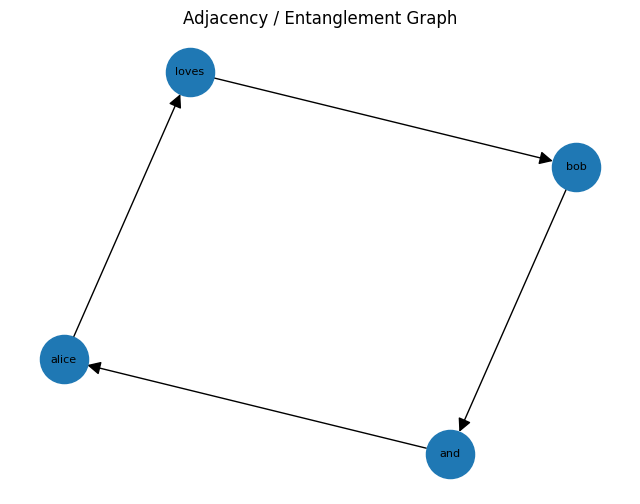

In [9]:
# --- Save/export results and plots
import json
from pathlib import Path

# Export candidate sets for each bit
export = []
for t, pair in zip(tokens, pairs):
    cands = rep.disambiguate_tokens(pair[0], pair[1])
    export.append({'token': t, 'pair': pair, 'candidates': sorted(cands)})

out_dir = Path('outputs')
out_dir.mkdir(exist_ok=True)

with open(out_dir / 'disambiguation_results.json', 'w') as f:
    json.dump(export, f, indent=2)

print('Saved disambiguation results to', out_dir / 'disambiguation_results.json')

# Export entanglement graph figure
fig, ax = plt.subplots(figsize=(8,6))
nx.draw(G, pos, ax=ax, with_labels=False, node_size=1200, arrowsize=20, width=[max(1,w) for w in weights])
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, ax=ax)
ax.set_title('Adjacency / Entanglement Graph')
fig.savefig(out_dir / 'entanglement_graph.png', dpi=150)
print('Saved entanglement graph to', out_dir / 'entanglement_graph.png')

["## Conclusion\n\n- **N-token LUTs** provide mutually-exclusive "clouds" of candidate tokens for each `(reg, zeros)` bit.\n- **Intersection** across n-groups narrows candidates quickly without needing multi-seed hashing (though that can further refine).\n- **Adjacency Matrix (AM)** stores transition frequencies and enables greedy or beam-search traversal to reconstruct original token order.\n\n### Extensions\n- Add multi-seed triangulation to further prune candidates\n- Use entanglement/lattice constraints for smarter reconstruction\n- Integrate with persistent LUT store (DuckDB) and C-backend HLLSet for production workloads"]